In [1]:
import sys

import ginsim
import biolqm
import pypint
import maboss

# Immune fate and Treg to Th17 reprogramming

We will analyze here a model published by Abou-Jaoudé et al. showing the differentiation and plasticity of helper T lymphocytes, and covering the Th1, Th2, Th9, Th17, Th22, Tfh, and Treg lineages. The original publication is available as [doi:10.3389/fbioe.2014.00086](https://dx.doi.org/10.3389%2Ffbioe.2014.00086).

In this notebook, we will focus on the balance between Th17 and Treg phenotypes which will enable us to apply some simplifications to the model, greatly facilitating the analysis.



## Load the model

We load the published model from an online model repository and display the regulatory graph using GINsim.

Downloading 'http://ginsim.org/sites/default/files/Frontiers-Th-Full-model-annotated.zginml'

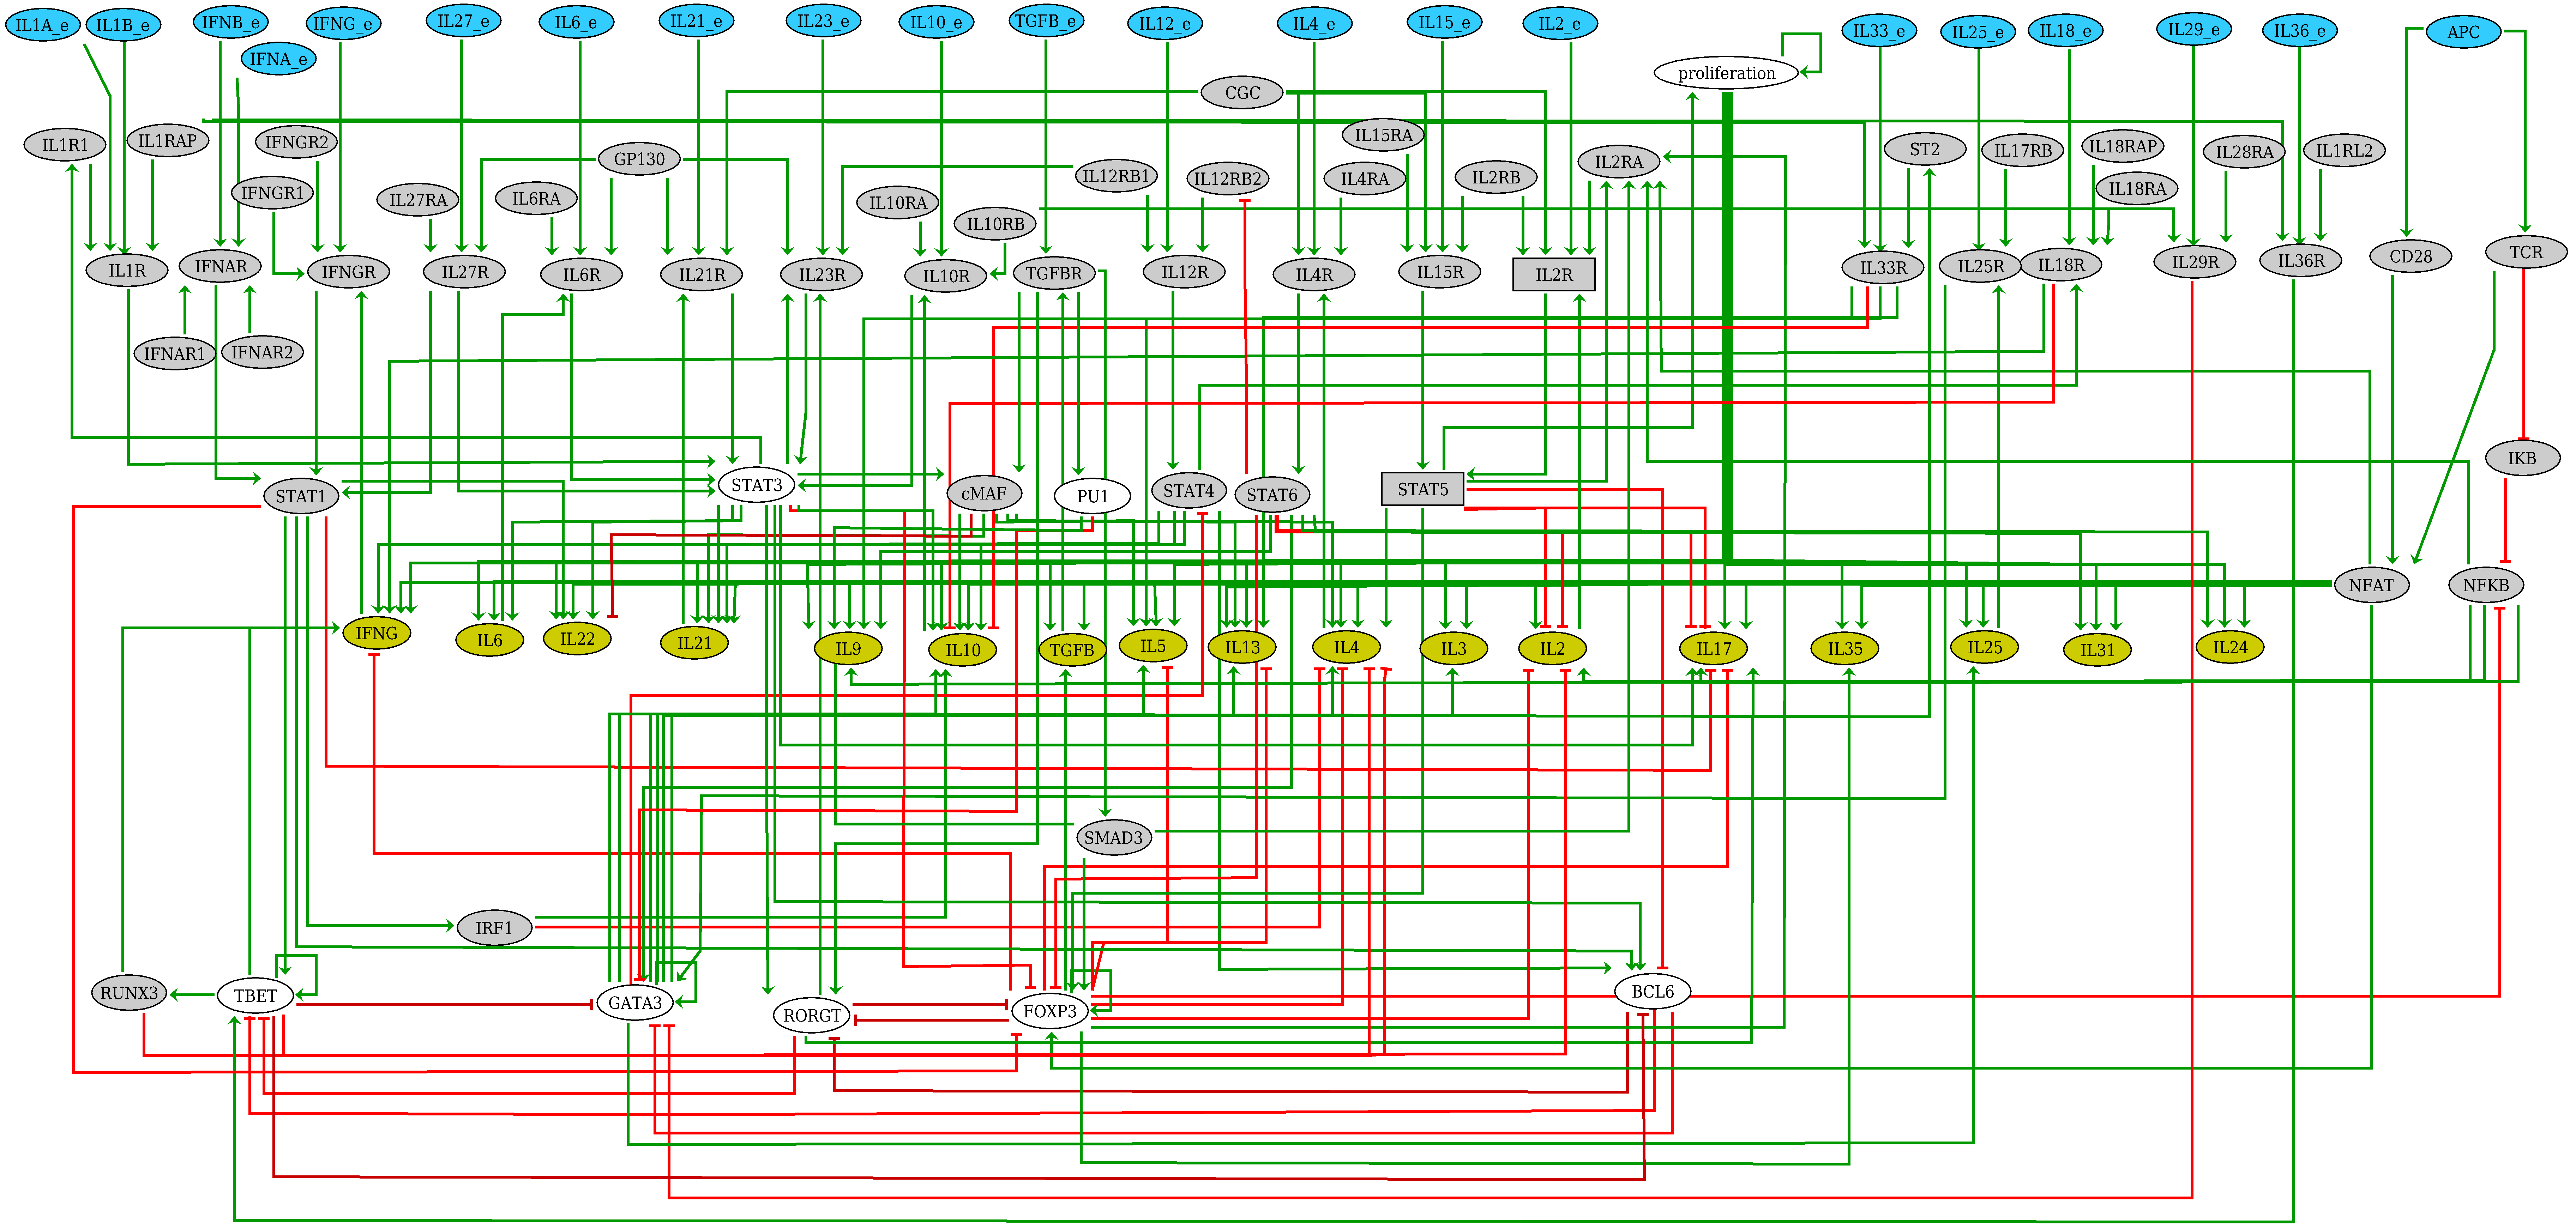

In [2]:
lrg = ginsim.load("http://ginsim.org/sites/default/files/Frontiers-Th-Full-model-annotated.zginml")
m = ginsim.to_biolqm(lrg)
ginsim.show(lrg)

## Define environments, phenotypes and reduction


This model encompasses a large number of "input" cytokines describing the cellular environment, which can in turn activate various cellular pathways.  
Here, we will focus on a limited set of well-controlled environments known to polarize Th differentiation toward the Th17 and Treg lineages. Please refer to the publication by Abou-Jaoudé et al. for a full description of all included T Helper phenotypes. 

> Table: key properties of Treg and Th17 lineages :
  
| Lineage | Master regulator | Secreted cytokines | Polarizing environment |
|---------|------------------|--------------------|------------------------|
| Th17    | RORgt            | IL17               | APC + TGFb + IL6       |
| Treg    | Foxp3            | TGFb               | APC + TGFb + IL2       |

Note that the presence of Antigen Presenting Cells (APCs) is required for any Th activation and differentiation. All other input cytokines which do not intervene in these environments will be considered as inactive, leading to a strong simplification of our model.

In the following cell, we define a reduced model in which all inputs are fixed in their inactive state, except APC and TGFb which are fixed in their active state, and IL2 and IL6 which are not fixed.

In [3]:
# Model simplification:
#   * Fix all inputs to their inactive state.
fixed = { str(n):0 for n in m.getComponents() if n.isInput() }
#   * Keep IL2 and IL6 as proper inputs 
del(fixed['IL2_e'])
del(fixed['IL6_e'])
#   * Fix the APC and TGFb inputs to their active state
fixed['TGFB_e'] = 1
fixed['APC'] = 1

# Apply the simplifications defined above to reduce the model
m_reduced = biolqm.perturbation(m, " ".join([ "%s%%%s" % (k,v) for (k,v) in fixed.items() ]))
m_reduced = biolqm.reduce(m_reduced, ":fixed :purge :no-extra")

Then we define the signature states for the Th17 and Treg lineages. These signatures include additional constraints to exclude markers from other lineages (i.e. they define the canonical lineage, not the hybrid states).

In [4]:
# Define phenotype patterns
treg_state = {'TBET':0,'RORGT':0,'FOXP3':1,'BCL6':0,'IFNG':0,'IL17':0}
th17_state = {'TBET':0,'RORGT':1,'FOXP3':0,'BCL6':0,'IFNG':0,'IL17':1}

# Define environments
th17_env  = {"IL2_e":0, "IL6_e":1}
treg_env  = {"IL2_e":1, "IL6_e":0}
mixed_env = {"IL2_e":1, "IL6_e":1}

# Define reporter components
reporter_components = ["TBET", "RORGT", "FOXP3", "IFNG", "IL2", "TGFB", "IL17"]

## Phenotypes represented - Analysis of the fixpoints

A first step to analyze this reduced model is to find out the phenotypes it can depict. 

Here we compute the fixpoints (stable states) which are compatible with our reduction, pro-treg and pro-th17 polarizing environments. This analysis identifies all possible fixpoints, but can not be directly used to asses their reachability.

Note that for the sake of clarity, the list of fixpoints is further compressed to show only the state of a few interesting reporter components.

In [5]:
fps = biolqm.fixpoints(m_reduced, autoconvert=False
      ).project_on_components( reporter_components + ["IL2_e", "IL6_e",])
biolqm.states_to_dataframe(fps)

,IL2_e,IL6_e,TBET,RORGT,FOXP3,IFNG,IL2,IL17,TGFB
0,0,0,0,1,0,0,1,1,0
1,0,0,1,0,0,1,1,0,0
2,0,1,0,1,0,0,1,1,0
3,1,0,0,0,1,0,0,0,1
4,1,0,1,0,1,0,0,0,1
5,1,0,0,1,0,0,1,1,0
6,1,0,1,0,0,1,1,0,0
7,1,1,0,0,1,0,0,0,1
8,1,1,0,1,0,0,1,1,0
9,1,1,1,0,1,0,0,0,1


We observe that :

* without IL2 nor IL6, we obtain Th17 and Th1 phenotypes
* with IL6 and no IL2, we obtain only Th17
* with IL2 and no IL6, we obtain Treg, Th1, Th17 and a hybrid Th1-Treg
* with both IL2 and IL6, we obtain Treg, Th17 and the same Th1-Treg hybrid


## Activation and differentiation of naive cells in polarizing environments

To evaluate the fate of naive Th cells upon activation in controlled environments, we can perform dynamical simulations starting from an initial condition representing a naive state.

Using the MaBoSS tool, we perform a stochastic sampling of the possible trajectories to estimate the asymptotic cell fate.

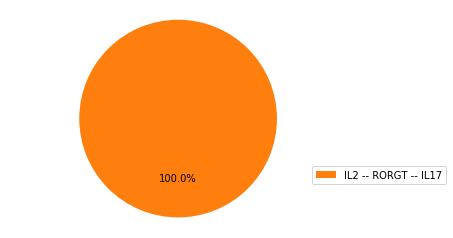

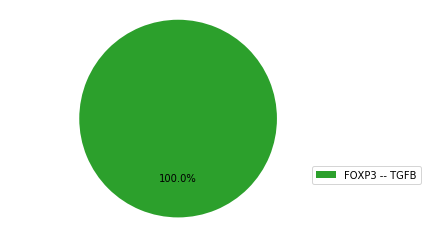

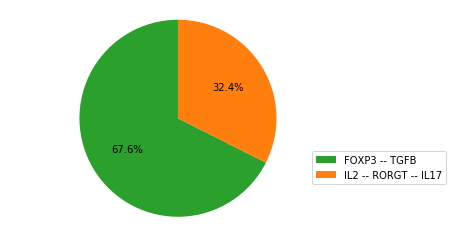

In [6]:
# Export the reduced model for analysis with the maboss tool
mabModel = biolqm.to_maboss(m_reduced)
mabModel.network.set_output(reporter_components)
mabModel.update_parameters(time_tick=2, max_time=300)
for comp in mabModel.network:
    mabModel.network.set_istate(comp, [1, 0])

# Clone and adapt it for the pro-Th17, Treg, and mixed environments
mab_th17 = mabModel.copy()
mab_th17.network.set_istate('IL6_e', [0,1])

mab_treg = mabModel.copy()
mab_treg.network.set_istate('IL2_e', [0,1])

mab_mixed = mabModel.copy()
mab_mixed.network.set_istate('IL2_e', [0,1])
mab_mixed.network.set_istate('IL6_e', [0,1])


# Perform all three simulations
for model in mab_th17, mab_treg, mab_mixed:
    result = model.run()
    result.plot_piechart()

We observe that naive Th cells are all converted into Th17 (resp. Treg) under the corresponding polarizing environment. 

Using a mixed environment (TGFb + IL2 + IL6), we obtain a mixture of Th17 and Treg phenotypes.

## Reprogramming Treg cells into Th17

We want to assess the possibility of Treg cells reprogrammation into Th17.

For this, we will start from fixpoints corresponding to the Treg phenotype obtained in a pro-Treg environment. We will subsequently change the value of the inputs to a pro-Th17 environment. As the pro-Th17 environment supports only a Th17-like fixpoint, we expect to be able to reprogramm all Treg cells into Th17.

In practice, we will first use the fixpoints corresponding to Treg cells as initial states before changing the activity of the IL2 and IL6 input components to mimic the pro-Th17 environment.

In [7]:
# Find all fixpoints (without projection)
fps = biolqm.fixpoints(m_reduced, autoconvert=False)
df_fps = biolqm.states_to_dataframe(fps)


# Define a helper function to select the desired subset of fixpoints
def filter_pattern(df, pattern):
    result = df
    for k,v in pattern.items():
        result = result.loc[ result[k]==v ]
    return result

In [8]:
# Select the fixpoints matching a Treg phenotype in a pro-Treg environment (IL2 is present, IL6 absent)
treg_fps = filter_pattern(df_fps, {**treg_state, "IL2_e":1, "IL6_e":0 })
treg_fps

,IL2_e,IL6_e,IFNGR,IL2R,IL6R,IL10R,IL21R,IL1R1,TBET,RORGT,...,STAT1,STAT3,STAT5,cMAF,TGFB,IRF1,RUNX3,proliferation,NFKB,IL35
3,1,0,0,2,0,0,0,0,0,0,...,0,0,2,0,1,0,0,1,0,1
5,1,0,0,2,1,1,1,1,0,0,...,0,1,2,1,1,0,0,1,0,1


In [9]:
# Similarly, to be used as reference in later analyses, select the fixpoint corresponding to a Th17 phenotype under pro-th17 environment
th17_fps = filter_pattern(df_fps, {**th17_state, "IL2_e":0, "IL6_e":1 })
th17_fps

,IL2_e,IL6_e,IFNGR,IL2R,IL6R,IL10R,IL21R,IL1R1,TBET,RORGT,...,STAT1,STAT3,STAT5,cMAF,TGFB,IRF1,RUNX3,proliferation,NFKB,IL35
2,0,1,0,2,1,1,1,1,0,1,...,0,1,2,1,0,0,0,1,1,0


### Can Treg cells be reprogrammed into Th17 cells ?

After identifying the stable states for our study, we evaluate if the reprogrammation of Treg cells to Th17 is possible in our in-silico model.

Using the Pint tool and model checking, we specify an initial condition matching the previous Treg fixpoints within a pro-Th17 environment. We then verify that at least one trajectory connects this initial condition to a Th17 signature state.

In [10]:
# convert our model to a format usable by Pint
pint_mr = biolqm.to_pint(m_reduced)

# For each treg fixpoint, test if it can be turned into a Th17 phenotype
for k,state in treg_fps.to_dict(orient="index").items():
    print(pint_mr.having({**state, **th17_env}).reachability(th17_state))

True
True


The previous result lets us concluded that a Th17-like phenotype can indeed be reached. But it does not guarantee that this phenotype is fixed, and that we cannot escape it. To complement this analysis, we can refine the reachability goal by replacing the simple Th17 pattern with a known fixpoint to ensure that we can reach a stable Th17 phenotype.

In [11]:
# Use the previously identified Th17 fixpoint as reachability goal.
# the final [2] correspond to the row index in the th17_fps dataframe as shown above
th17_stable = th17_fps.to_dict(orient="index")[2]

# For each Treg fixpoint, assess the reachability of the Th17 fixpoint
for k,state in treg_fps.to_dict(orient="index").items():
    print(pint_mr.having({**state, **th17_env}).reachability(th17_stable))

True
True


As expected, Treg cells can be reprogrammed into Th17 using a pro-th17 environment. We also showed that this corresponds to a stable phenotype. 

### Can Treg cells be reprogrammed into Th17 cells in a mixed environment ?

The preceeding results would correspond to in vitro reprogramming experiments where the cellular environment can be perfectly constrained. However, in vivo, the desired reprogramming would need to happen in a mixed environment also containing pro-Treg IL2 cytokines.

What happens to Treg cells in a mixed environment which can sustain several cell lineages? Can we reach even transiently a Th17 phenotypes? To answer these questions we adapt the initial environment in the previous analysis to also include IL2 in addition to IL6 and TGFB.

In [12]:
# For each treg fixpoint, test if it can be turned into a Th17 phenotype in the mixed environment
for k,state in treg_fps.to_dict(orient="index").items():
    print(pint_mr.having({**state, **mixed_env}).reachability(th17_state))

False
False


We observe that Treg embded in a mixed environment cannot be turned into Th17, even transiently. This reprogrammation is not possible under continuous stimulation by both IL2 and IL6 (this experiment) but it becomes possible after the complete removal of IL2 from the environment (previous experiment). 

However, as Th17 cells obtained by reprogrammation will later become IL2 producers, we suspect that Th17 cells are not impacted by the presence of IL2 in their enviroment at a later stage.

To refine this observation, we turn off the IL2 receptor in the initial condition, while keeping IL2 in the environment. The cells can then reactivate the IL2 receptor at any time. Then we check if this transient shutdown is sufficient to enable the reprogrammation process.

In [13]:
# For each treg fixpoint, test if it can be turned into a Th17 phenotype in the mixed environment
for k,state in treg_fps.to_dict(orient="index").items():
    print(pint_mr.having({**state, **mixed_env, "IL2R":0}).reachability(th17_state))

True
True


Interestingly, we saw that a transient shutdown of the IL2 receptor is sufficient to reach an IL7 phenotype at least transiently. We then want to assess if the inhibition of the IL2 receptor would achieve the same objective. Here we lock the component representing the IL2 receptor in its inactive state before performing the same analysis as before. Surprisingly, a full inhibition of IL2R completely prevents the reprogrammation.

In [14]:
# For each treg fixpoint, test if it can be turned into a Th17 phenotype in the mixed environment
for k,state in treg_fps.to_dict(orient="index").items():
    print(pint_mr.lock({"IL2R":0}).having({**state, **mixed_env}).reachability(th17_state))

False
False


# Quantification of the reprogrammation with MaBoSS

Now that we know that the reprogrammation is possible, we use stochatstic simulations to obtain an estimation of its efficiency and a computation of the involved trajectories.

## Pro-Th17 environment

First, we perform simulations in a pure pro-Th17 environment to assess the reprogrammation of Treg cells in absence of IL2. 

The model needs first to be converted to a format usable by MaBoSS (Boolean). We then perform the same experiments as described above to determine the proportion of Treg reprogrammation in a pure pro-th17 environment. As expected, we obtain a full reprogrammation to the Th17 phenotype.

In [15]:
# Conversion into a model usable by MaBoSS
mabModel = biolqm.to_maboss(m_reduced)

# Set output values to present in visualisations
mabModel.network.set_output(reporter_components + ["IL2R_b1"])

# Set max time of simulation + time ticks
mabModel.update_parameters(time_tick=2, max_time=250)

In [16]:
# As MaBoSS uses only fully Boolean models, compute booleanized treg stable states
mr_treg = biolqm.booleanize( m_reduced )
fixpoints = biolqm.fixpoints(mr_treg, autoconvert=False)
fixpoints.setExtra(True)
fixpoints = biolqm.states_to_dataframe(fixpoints)

treg_fps = filter_pattern(fixpoints, {**treg_state, "IL2_e":1, "IL6_e":0 })

In [17]:
# Helper function to easily set component values in initial states
def set_maboss_init(mabModel, state):
    for comp,v in state.items():
        if v == 0:
            mabModel.network.set_istate(comp, [1, 0])
        elif v == 1:
            mabModel.network.set_istate(comp, [0, 1])
        else:
            raise("non-boolean values are unsupported (%s=%s)" % (comp,v))

In [18]:
# Container for results of simulations
results = []
# For each Treg stable state
for core_state in treg_fps.to_dict(orient="index").values():
    # Initialize the core components with a Treg stable state
    set_maboss_init(mabModel, core_state)
    # Convert inputs to pro-Th17
    mabModel.network.set_istate('IL6_e', [0,1])
    mabModel.network.set_istate('IL2_e', [1,0])
    # Run simulation
    print("running maboss simulation...")
    results.append(mabModel.run())

running maboss simulation...
running maboss simulation...


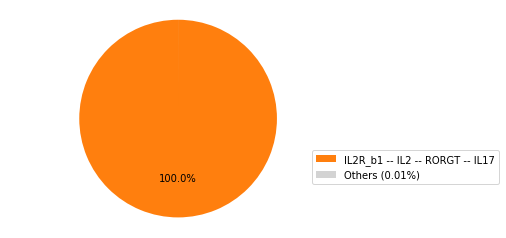

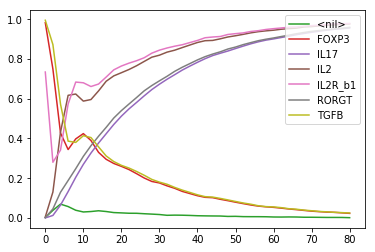

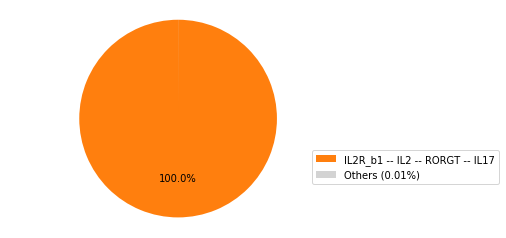

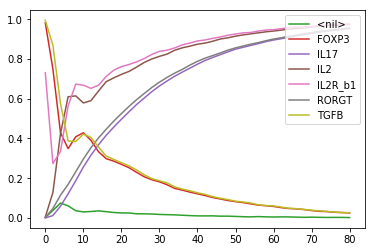

In [19]:
# Display results
for r in results:
    # Pie chart with percentages of each phenotype
    r.plot_piechart()
    # Trajectories
    r.plot_node_trajectory(until=80)

# Mixed environment with transient shutdown of IL2 receptor

As explained above, the mixed and pro-Th17 environments differing solely by the presence of IL2, initial inactivation the IL2 receptor enables to start the reprogrammation toward the Th17 phenotype, which itself produces IL2.

We can further check the effect of a transient decrease of IL2.

In [20]:
# Container for results of simulations
results = []
# For each Treg stable state
for core_state in treg_fps.to_dict(orient="index").values():
    # Initialize the core components with a Treg stable state, mixed environment (IL2+IL6) and inactivation of IL2 receptor
    set_maboss_init(mabModel, {**core_state, "IL6_e":1, "IL2_e":1, "IL2R_b1":0, "IL2R_b2":0})
    # Run simulation
    print("running maboss simulation...")
    results.append(mabModel.run())

running maboss simulation...
running maboss simulation...


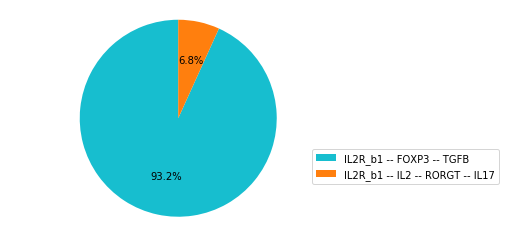

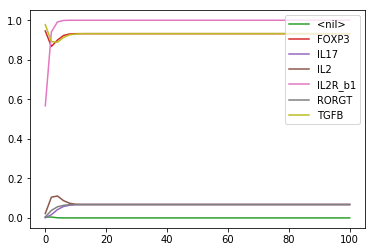

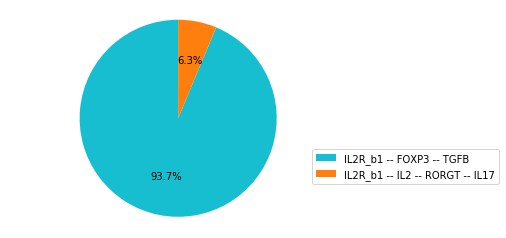

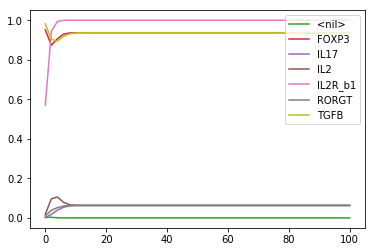

In [21]:
# Display results
for r in results:
    # Pie chart with percentages of each phenotype
    r.plot_piechart()
    # Trajectories
    r.plot_node_trajectory(until=100)
